**Github Repository Link:**
https://github.com/achinthya360/ECE188DeepLearningAttacks/

# Perform an Adversarial attack.

For the second part of the project we consider a trained model (MobileNet) which is trained on the imagenet dataset. 

We use an evasion attack called [FGSM](https://neptune.ai/blog/adversarial-attacks-on-neural-networks-exploring-the-fast-gradient-sign-method#:~:text=The%20Fast%20Gradient%20Sign%20Method%20(FGSM)%20combines%20a%20white%20box,model%20into%20making%20wrong%20predictions.) to fool the neural network into making incorrect predictions.

## Import Packages.

Import the necessary packages we continue to use Tensorflow and Keras

In [2]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras.preprocessing import image

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

## Load the Pretrained model. 

We use the [MobileNetV2](https://arxiv.org/abs/1801.04381) model trained on the [Imagenet](https://www.image-net.org/) dataset. 

In [3]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14548992/14536120 [==============================] - 0s 0us/step


### Helper Function for Data Processing


Following functions can be used for data processing. Dont worry about these, just use them. 

In [4]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

## Load an Image. 


Load any image, we consider an image of a Golden Retriever. 

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
image_raw = tf.io.read_file('/content/drive/MyDrive/UCLA/3rd Year/Spring Quarter/188/Adversarial Attack Project/golden_retriever.jpeg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

49152/35363 [=========================================] - 0s 0us/step


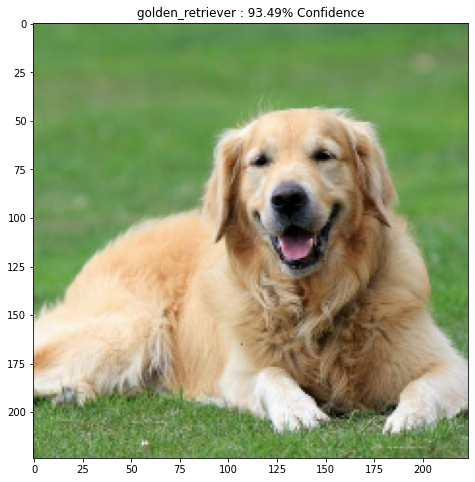

In [8]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## Create the Adversarial Image. 

We use the FGSM method to create an adversarial image. Be sure to read about FGSM to understand how the attack works. 

In [9]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

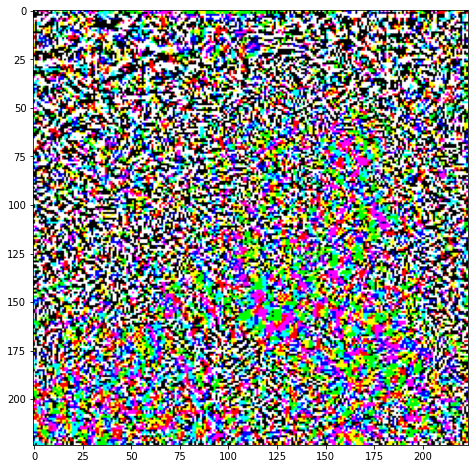

In [10]:
# Get the input label of the image.
golden_retriever_index = 207
label = tf.one_hot(golden_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [11]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

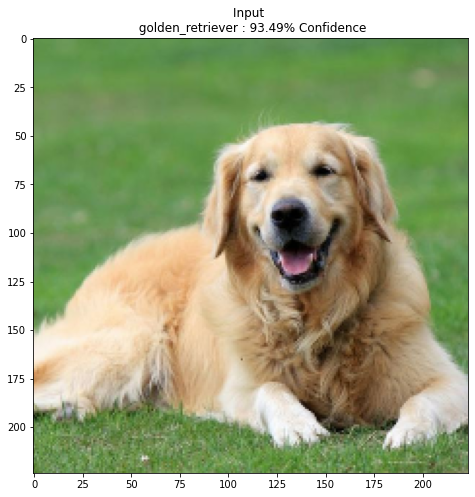

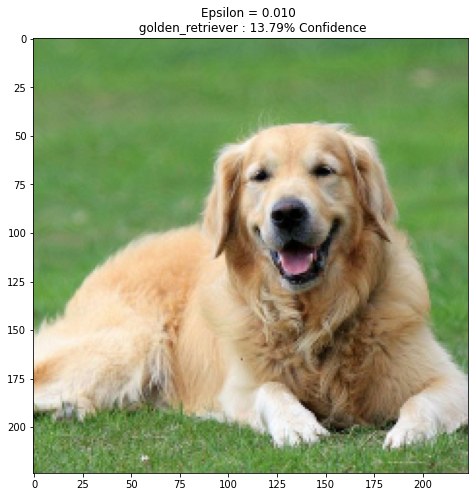

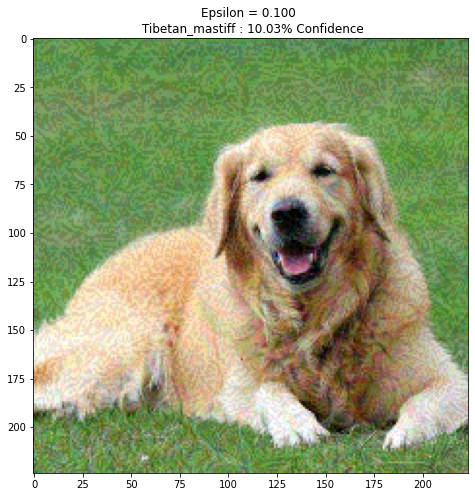

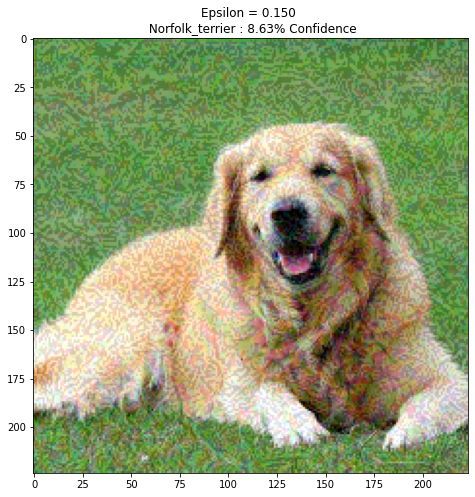

In [12]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

# Task2: Perform an Analysis to understand the potency of the attack. 

Your task here is to understand how small a change could change the class output and this is measured by the epsilon value needed to change the class. 

Your task is as follows:

* Pick 10 images each from different classes in imagenet. 
* Perform a perturbation analysis on each of these images. 
* In the analysis you are required to report the smallest epsilon value for which you notice a class change. 
* Make a table for each of the images considered with the minimum epsilon value for the FGSM attack. 

Write the Code for the above below. You can add the table also below. 

In [13]:
# load 10 images
images = ["baboon", "beaver", "brain_coral", "cannon", "dowitcher", "golden_retriever", "hammer", "lynx", "rhinoceros_beetle", "zebra"]
indices = [372, 337, 109, 471, 142, 207, 587, 287, 306, 340]

epsilons = []
data = []
for i, name in enumerate(images):
  filename = ("/content/drive/MyDrive/UCLA/3rd Year/Spring Quarter/188/Adversarial Attack Project/"+name+".jpeg")
  image_raw = tf.io.read_file(filename)
  image = tf.image.decode_image(image_raw)

  image = preprocess(image)
  image_probs = pretrained_model.predict(image)
  eps = 0
  label = name

  # create pertubation 
  classname = tf.one_hot(indices[i], image_probs.shape[-1])
  classname = tf.reshape(classname, (1, image_probs.shape[-1]))

  perturbations = create_adversarial_pattern(image, classname)

  while(label == name):
    # add perturbation with epsilon
    adv_x = image + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    _, label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))
    eps += 0.01

  # append the minimum required epsilon for each class to a list
  epsilons.append(eps)
  data.append([name, eps])

In [14]:
# print results table
from tabulate import tabulate
print (tabulate(data, headers=["Class", "Min Epsilon to Change the Label"]))

Class                Min Epsilon to Change the Label
-----------------  ---------------------------------
baboon                                          0.02
beaver                                          0.03
brain_coral                                     0.43
cannon                                          0.03
dowitcher                                       0.24
golden_retriever                                0.04
hammer                                          0.05
lynx                                            0.02
rhinoceros_beetle                               0.02
zebra                                           0.39




```
Class                Min Epsilon to Change the Label
-----------------  ---------------------------------
baboon                                          0.02
beaver                                          0.03
brain_coral                                     0.43
cannon                                          0.03
dowitcher                                       0.24
golden_retriever                                0.04
hammer                                          0.05
lynx                                            0.02
rhinoceros_beetle                               0.02
zebra                                           0.39
```



# Task3: Compare the robustness of the considered model with other models. 

Your task here is to compare how this model (MobileNetV2) compares with other popular object detection models. 

Your task is as follows:

* Consider 5 different models (you can consider various RESNET architectures, any models you find interesting).
* Load the pre-trained weights of the model (trained on imagenet). 
* Perform Task2 on all the considered models. 
* Add all the results in the table. Hence the final table you have 6 columns for each model and epsilon values for each of the 10 images for all 6 models. 


What do you observe? Why do you think this is the case? 

Write the Code for the above below. You can also add the table and answer to the question below. 


In [15]:
pretrained_models = [tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet'),
                     tf.keras.applications.DenseNet121(include_top=True, weights='imagenet'),
                     tf.keras.applications.ResNet101(include_top=True, weights='imagenet'),
                     tf.keras.applications.NASNetMobile(include_top=True, weights='imagenet'),
                     tf.keras.applications.EfficientNetB0(include_top=True, weights='imagenet')]
for model in pretrained_models:
  model.trainable = False

21848064/21834768 [==============================] - 0s 0us/step


In [16]:
import numpy as np
cols = 6
rows = 10
data = np.zeros((rows, cols), dtype=object)
for i, name in enumerate(images):
  filename = ("/content/drive/MyDrive/UCLA/3rd Year/Spring Quarter/188/Adversarial Attack Project/"+name+".jpeg")
  image_raw = tf.io.read_file(filename)
  image_dec = tf.image.decode_image(image_raw)

  data[i, 0] = name

  for m, model in enumerate(pretrained_models):
    image = preprocess(image_dec)
    image_probs = model.predict(image)
    eps = 0
    label = name

    # create pertubation 
    classname = tf.one_hot(indices[i], image_probs.shape[-1])
    classname = tf.reshape(classname, (1, image_probs.shape[-1]))

    perturbations = create_adversarial_pattern(image, classname)

    while(label == name):
     # add perturbation with epsilon
      adv_x = image + eps*perturbations
      adv_x = tf.clip_by_value(adv_x, -1, 1)
      _, label, confidence = get_imagenet_label(model.predict(adv_x))
      eps += 0.01

    # append the minimum required epsilon for each class to a list
    data[i, m+1] = eps

In [17]:
# print results table
from tabulate import tabulate
print (tabulate(data, headers=["Class", "MobileNetV2 Eps", "DenseNet121 Eps", "ResNet101 Eps", "NASNetMobile Eps", "EfficientNetB0 Eps"]))

Class                MobileNetV2 Eps    DenseNet121 Eps    ResNet101 Eps    NASNetMobile Eps    EfficientNetB0 Eps
-----------------  -----------------  -----------------  ---------------  ------------------  --------------------
baboon                          0.02               0.13             0.01                0.13                  0.01
beaver                          0.03               0.46             0.01                0.41                  0.01
brain_coral                     0.43               0.99             0.01                0.82                  0.01
cannon                          0.03               0.22             0.01                0.39                  0.01
dowitcher                       0.24               0.45             0.01                0.48                  0.01
golden_retriever                0.04               0.45             0.01                0.53                  0.01
hammer                          0.05               0.22             0.01        



```
Class                MobileNetV2 Eps    DenseNet121 Eps    ResNet101 Eps    NASNetMobile Eps    EfficientNetB0 Eps
-----------------  -----------------  -----------------  ---------------  ------------------  --------------------
baboon                          0.02               0.13             0.01                0.13                  0.01
beaver                          0.03               0.46             0.01                0.41                  0.01
brain_coral                     0.43               0.99             0.01                0.82                  0.01
cannon                          0.03               0.23             0.01                0.38                  0.01
dowitcher                       0.24               0.45             0.01                0.48                  0.01
golden_retriever                0.04               0.45             0.01                0.52                  0.01
hammer                          0.05               0.22             0.01                0.32                  0.01
lynx                            0.02               0.06             0.01                0.09                  0.01
rhinoceros_beetle               0.02               0.45             0.01                0.11                  0.01
zebra                           0.39               0.61             0.01                0.67                  0.01
```
The results show that ResNet101 and EfficientNetB0 are most susceptible to the FGSM attack while the NASNetMobile and DenseNet121 appear to be stronger against FGSM perturbations than the MobileNetV2. 

At a glance, it seems like architectures with greater layer depths maintain greater accuracy against perturbations. For example, the DenseNet has 300+ depth whereas MobileNetV2 only has ~100, and DenseNet requires much higher epsilon values for the perturbations to actually impact the image classification. 


# BONUS: Can you provide a better attack?

Can you design a better attack that lowers the epsilon required for the images?

Task:

* Design another attack. 
* Compare the epsilon values on 10 images. 
* Does it perform better than the FGSM attack? That is, does it have lower epsilon values?

Write the code and provide your answers below. 